# Instalación de las librerías

In [1]:
!pip install ultralytics
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Carga de librerías

In [2]:
import os
import random

from ultralytics import YOLO
import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import yaml

# Descarga dataset

In [3]:
# Download data from repository and unzip
%cd /content
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.001 -O trafic_data.zip.001
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.002 -O trafic_data.zip.002
!7z x -y -sdel trafic_data.zip.001
!rm trafic_data.zip.* -f

/content
--2024-04-15 13:46:06--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘trafic_data.zip.001’

trafic_data.zip.001 100%[===================>] 100.00M   306MB/s    in 0.3s    

2024-04-15 13:46:13 (306 MB/s) - ‘trafic_data.zip.001’ saved [104857600/104857600]

--2024-04-15 13:46:14--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Dataset/trafic_data.zip.002
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.

# Descarga del modelo

In [4]:
# Download the model and unzip
%cd /content
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.001 -O yolov8x.zip.001
!wget https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.002 -O yolov8x.zip.002
!7z x -y yolov8x.zip.001
!rm yolov8x.zip.* -f

/content
--2024-04-15 13:46:25--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘yolov8x.zip.001’

yolov8x.zip.001     100%[===================>] 100.00M   334MB/s    in 0.3s    

2024-04-15 13:46:33 (334 MB/s) - ‘yolov8x.zip.001’ saved [104857600/104857600]

--2024-04-15 13:46:33--  https://raw.githubusercontent.com/Laboratorios-2-MIT-MC/IA-Ciber/main/Pr%C3%A1cticas/Proyecto%20Final/Modelo/yolov8x.zip.002
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuse

# Exploración del dataset

In [5]:
# Path to files and labels
train_images = "/content/trafic_data/train/images"
train_labels = "/content/trafic_data/train/labels"

valid_images = "/content/trafic_data/train/images"
valid_labels = "/content/trafic_data/train/labels"

In [6]:
def loadLabels(image_file, image_labels):
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(image_labels, label_file)

    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    return labels

def plotObjectDetections(ax, image, labels):
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')

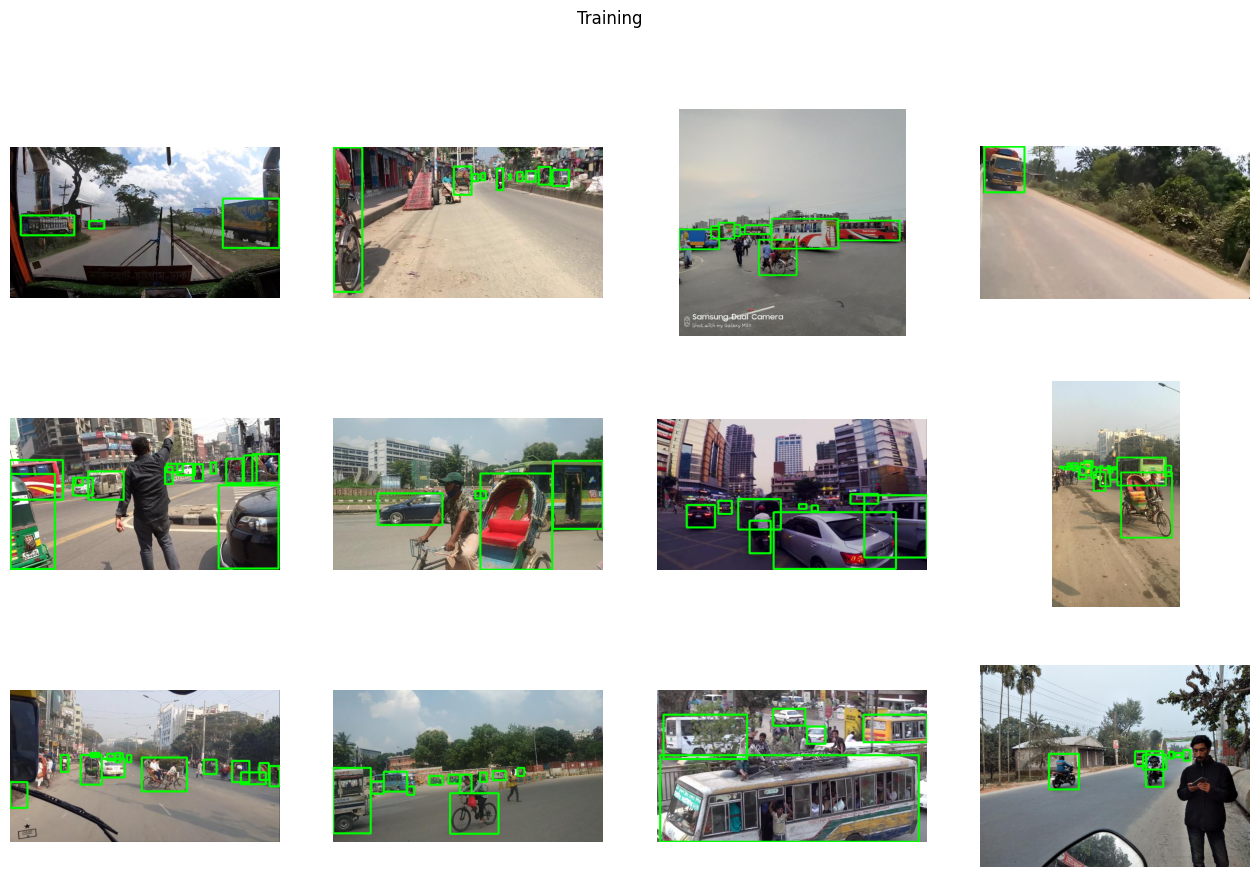

In [7]:
# List of all the training images
image_files = os.listdir(train_images)

# Choose 12 random image files from the list
random_images = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)

    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    labels = loadLabels(image_file, train_labels)

    # Plot object detections
    plotObjectDetections(axs[row, col], image, labels)

plt.suptitle("Training")
plt.show()

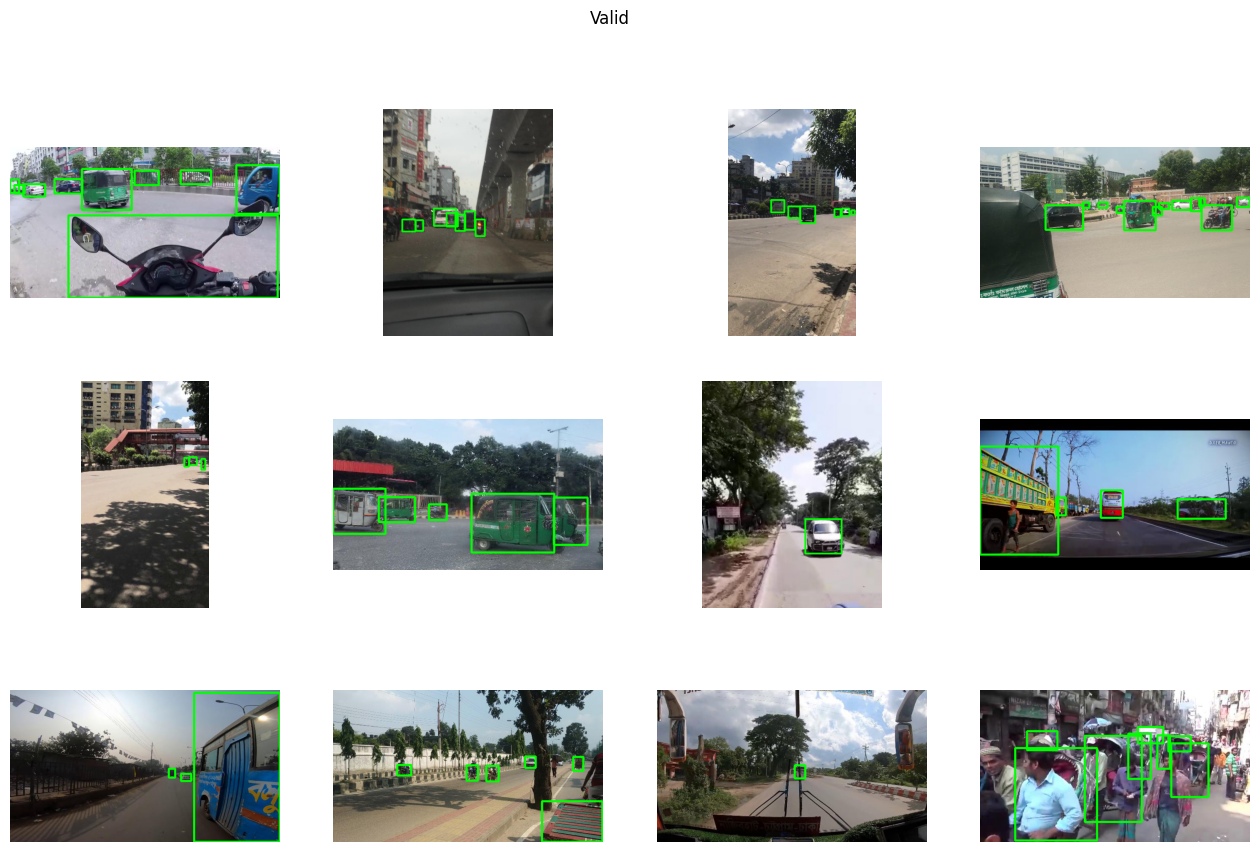

In [8]:
# List of all the valid images
image_files = os.listdir(valid_images)

# Choose 12 random image files from the list
random_images = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for i, image_file in enumerate(random_images):
    row, col = divmod(i, 4)

    # Load the image
    image_path = os.path.join(valid_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    labels = loadLabels(image_file, valid_labels)

    # Plot object detections
    plotObjectDetections(axs[row, col], image, labels)

plt.suptitle("Valid")
plt.show()

In [9]:
# Class names found on the Dataset
with open('/content/trafic_data/data_1.yaml', 'r') as f:
    data_yaml = yaml.load(f, Loader=yaml.FullLoader)

data_yaml["names"]

['ambulance',
 'army vehicle',
 'auto rickshaw',
 'bicycle',
 'bus',
 'car',
 'garbagevan',
 'human hauler',
 'minibus',
 'minivan',
 'motorbike',
 'pickup',
 'policecar',
 'rickshaw',
 'scooter',
 'suv',
 'taxi',
 'three wheelers -CNG-',
 'truck',
 'van',
 'wheelbarrow']

# Comprobación del rendimiento del modelo

In [79]:
# Cargamos el modelo preentrenado
%cd /content
model = YOLO("yolov8x.pt")

metrics = model.val(data = '/content/trafic_data/data_1.yaml', device='cuda:0')

# result_predict = model.predict(source = os.path.join(valid_images, random_images[0]), imgsz=(416))

# plot = result_predict[0].plot()
# plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(plot))

/content
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


val: Scanning /content/trafic_data/valid/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/trafic_data/valid/images/Pias--359-_PNG.rf.43bcf36efe5cf8c37552d2c45fffea60.jpg: 9 duplicate labels removed
val: WARNING ⚠️ /content/trafic_data/valid/images/Pias--360-_PNG.rf.8405b0e44009a9300e0a1100ccf7d5b3.jpg: 7 duplicate labels removed



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  16%|█▌        | 3/19 [00:03<00:20,  1.30s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.08s/it]


                   all        300       2568     0.0071     0.0629    0.00419    0.00327
            motorcycle        300         32    0.00516      0.906    0.00683    0.00293
              airplane        300        425     0.0833    0.00235     0.0463     0.0417
                   bus        300        842     0.0145     0.0451     0.0076    0.00487
                  boat        300          2          0          0          0          0
         traffic light        300        110          0          0          0          0
          fire hydrant        300        335          0          0          0          0
             stop sign        300        142          0          0          0          0
         parking meter        300          1          0          0          0          0
                 bench        300        192     0.0105     0.0521    0.00634    0.00277
                  bird        300          1          0          0          0          0
                   ca

In [67]:
print(metrics.box.map)    # map50-95
print(metrics.box.map50)  # map50
print(metrics.box.map75)  # map75
print(metrics.box.maps)   # a list contains map50-95 of each category

0.0032662107732823035
0.004191577395038353
0.003536167566610374
[  0.0032662   0.0032662   0.0032662   0.0029318    0.041713   0.0048532   0.0032662   0.0032662           0           0           0           0           0   0.0027617           0           0           0           0           0           0           0   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662
   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662
   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.0032662   0.00326


image 1/1 /content/trafic_data/train/images/Dipto_-90_jpg.rf.98a7e5c7e977c977b7db496662c33876.jpg: 256x416 1 person, 3 cars, 1 motorcycle, 1 bus, 2 trucks, 33.1ms
Speed: 1.6ms preprocess, 33.1ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 416)


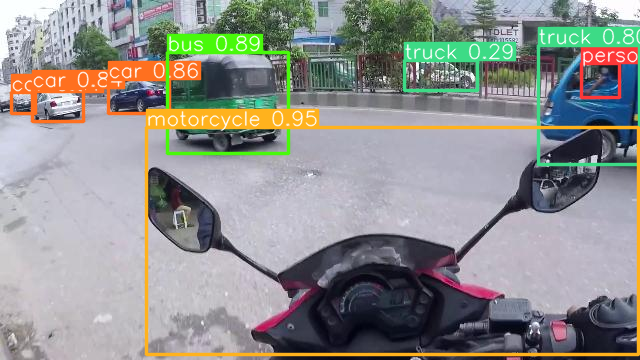

In [78]:
result_predict = model(source = os.path.join(valid_images, random_images[0]), imgsz=(416))

plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

# result_predict[0]

# Explicación del tipo de ataque

# Preparar el ataque

# Realizamos el ataque

# Análisis de los resultados del ataque

# Aplicaciones en la vida real